In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.weightstats import ttest_ind

from skimage.io import imread
import scipy.ndimage as sn

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix
)

from skimage import data, color
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from skimage.data import camera

# Hypothesis Testing Exercise
## Comparing Distributions. Testing statistical hypotheses. p-value. Goodness of fit

### Problem 1. t-test
You're given a dataset which describes the age at death among members of the sovereignty, aristocracy, and gentry. There is an explanation [here](http://www.stat.ufl.edu/~winner/data/agedeath.txt) and the actual data is [here](http://www.stat.ufl.edu/~winner/data/agedeath.dat). Get to know the data; plot histograms and / or boxplots, or other graphs as needed. Note that all ages are only for a certain social class of people and they won't represent the entire population of people.

Do the mean ages differ significantly ($\alpha = 5\%$)? Perform a t-test. Do you need an independent or paired test?

In [3]:
age_of_death_data = pd.read_fwf("https://users.stat.ufl.edu/~winner/data/agedeath.dat", header = None)

age_of_death_data.columns = ["Type", "Death", "Index"]

summary = age_of_death_data.groupby("Type").Death.describe()

print("Age-at-death summary by social rank")
print()
print(summary)

Age-at-death summary by social rank

       count       mean        std  min   25%   50%   75%   max
Type                                                           
aris  2291.0  60.146224  17.428857  0.0  48.0  62.0  74.0  99.0
gent  2455.0  57.145010  18.107512  0.0  44.0  60.0  71.0  99.0
sovr  1440.0  54.093750  16.097867  0.0  43.0  56.0  66.0  97.0


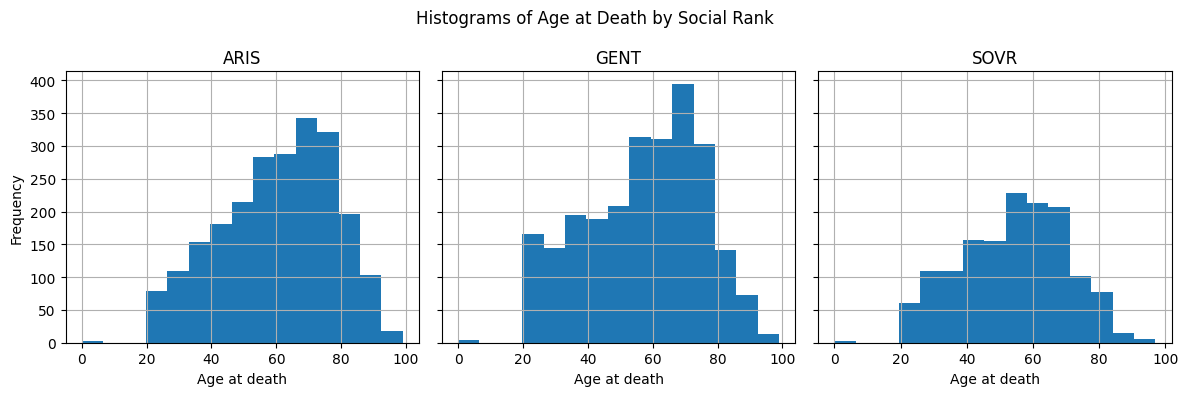

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

ranks = age_of_death_data.Type.unique()
for ax, rank in zip(axes, ranks):
    age_of_death_data[age_of_death_data.Type == rank].Death.hist(bins=15, ax=ax)
    ax.set_title(f"{rank.upper()}")  
    ax.set_xlabel("Age at death")
    
axes[0].set_ylabel("Frequency")
fig.suptitle("Histograms of Age at Death by Social Rank")
fig.tight_layout()
plt.show()

<Figure size 600x500 with 0 Axes>

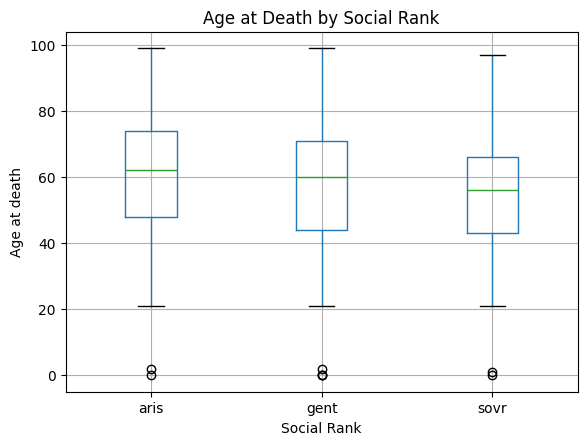

In [5]:
plt.figure(figsize=(6, 5))
age_of_death_data.boxplot(column="Death", by="Type")
plt.title("Age at Death by Social Rank")
plt.suptitle("")      
plt.xlabel("Social Rank")
plt.ylabel("Age at death")
plt.show()

In [6]:
sovr = age_of_death_data.loc[age_of_death_data.Type == "sovr", "Death"]
aris = age_of_death_data.loc[age_of_death_data.Type == "aris", "Death"]
gent = age_of_death_data.loc[age_of_death_data.Type == "gent", "Death"]

for g1, g2 in [("sovr", "aris"), ("sovr", "gent"), ("aris", "gent")]:
    t, p = st.ttest_ind(eval(g1), eval(g2))   
    print(f"{g1} vs {g2}:  t = {t:.2f},  p = {p:.4f}")

sovr vs aris:  t = -10.63,  p = 0.0000
sovr vs gent:  t = -5.29,  p = 0.0000
aris vs gent:  t = 5.81,  p = 0.0000


Let's try something else. In the `data/horse_beginners.dat` file, there's data about 8 people. Each person is a beginner in horse riding. They were asked to imagine how long their ride would take (for a fixed track length). After that, the actual times were measured.

Get acquainted with the data and draw some plots if you need (hint: boxplots are useful for comparing distributions). Are the people good at predicting their ride times? That is, are there significant differences between imagined and actual time (5%-level)? Also, is the imagined time **significantly longer** than the real time? Perform a t-test. Don't forget that the subjects are the same.

In [7]:
horse_data = pd.read_fwf("data/horse_beginners.dat")

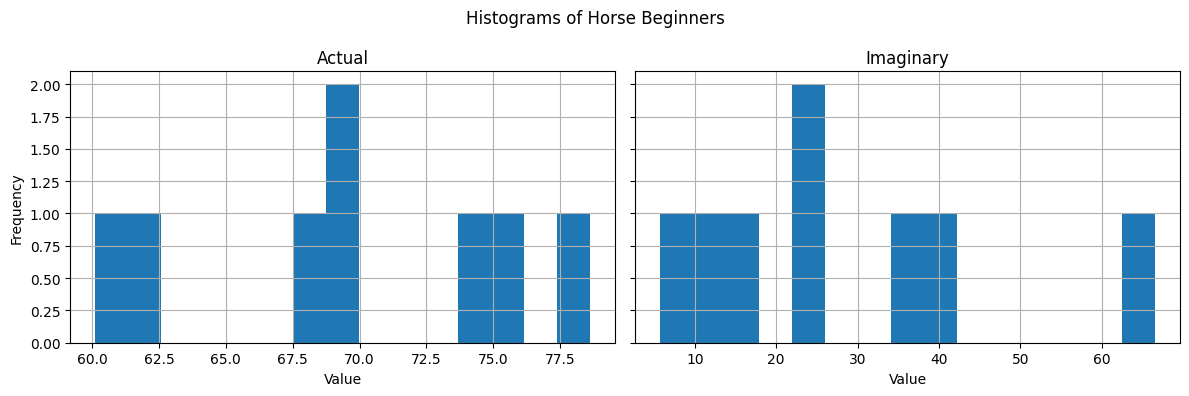

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

columns = ["Actual", "Imaginary"]
for ax, column in zip(axes, columns):
    horse_data[column].hist(bins=15, ax=ax)
    ax.set_title(column)  
    ax.set_xlabel("Value")
    
axes[0].set_ylabel("Frequency")
fig.suptitle("Histograms of Horse Beginners")
fig.tight_layout()
plt.show()

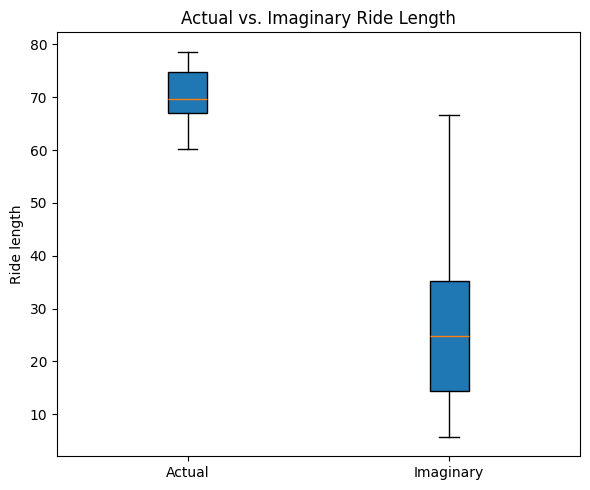

In [9]:
plt.figure(figsize=(6, 5))

plt.boxplot(
    [horse_data["Actual"], horse_data["Imaginary"]],
    tick_labels=["Actual", "Imaginary"],
    patch_artist=True, 
)

plt.title("Actual vs. Imaginary Ride Length")
plt.ylabel("Ride length")
plt.tight_layout()
plt.show()

In [10]:
actual = horse_data["Actual"]
imagined = horse_data["Imaginary"]

t_stat, p_two_sided = st.ttest_rel(imagined, actual)
print(f"Two-sided test : t = {t_stat:6.2f},  p = {p_two_sided:7.4f}")

if t_stat > 0:
    p_one_sided = p_two_sided / 2.0
else:
    p_one_sided = 1.0 - p_two_sided / 2.0
print(f"One-sided test : t = {t_stat:6.2f},  p = {p_one_sided:7.4f}")

Two-sided test : t =  -6.19,  p =  0.0004
One-sided test : t =  -6.19,  p =  0.9998


### Problem 2. ANOVA
Read [this](http://www.itl.nist.gov/div898/education/anova/newcar.dat) dataset. Get acquainted with it and plot graphics. Note that it's formatted a bit oddly. First, you have to skip some rows; second, the target variable is first (in most datasets, it's the last one). Well, that shouldn't bother you :).

Do the rates differ significantly ($\alpha = 0,05$) between cities? Apply one-way ANOVA to find out.

**Hint:** You have to group all values by city. You can get a dictionary of groups like this:
```python
groups = { k: v.tolist() for k, v in cars.groupby("City").Rate }
```

After that, you can use ```*groups.values()``` to pass all dictionary values as separate arguments to a function.

In [11]:
new_car_data = pd.read_fwf("data/newcar.dat", skiprows = 25, header = None)
new_car_data.columns = ["Rate", "City"]
groups = { k: v.tolist() for k, v in new_car_data.groupby("City").Rate }

F, p = st.f_oneway(*groups.values())
print(f"F-stat = {F:5.2f},  p-value = {p:7.4f}")

F-stat =  4.83,  p-value =  0.0012


Well, most analyses aren't so simple. Let's have a look at another dataset. This one is located [here](http://www.itl.nist.gov/div898/education/anova/ratfeed.dat). Get acquainted with it.

This time, we've got two explanatory variables: amount and type of diet.

Perform one-way ANOVA to each variable separately, disregarding the other one. 

To do this, take for example the "Amount" variable. Group all weights by amount, disregarding the diet type. Perform ANOVA on the groups, like you did before. Repeat the same process with "Diet".

Do the groups differ significantly at the 5%-level?

In [12]:
rat_feed_data = pd.read_fwf("data/ratfeed.dat", skiprows = 25, header = None)
rat_feed_data.columns = ["Weight", "Amount", "Type"]

In [13]:
amount_groups = [g.values for _, g in rat_feed_data.groupby("Amount")["Weight"]]

F_amt, p_amt = st.f_oneway(*amount_groups)

type_groups = [g.values for _, g in rat_feed_data.groupby("Type")["Weight"]]

F_typ, p_typ = st.f_oneway(*type_groups)

print(f"ANOVA on Amount : F = {F_amt:6.2f}, p = {p_amt:7.4f}")
print(f"ANOVA on Diet : F = {F_typ:6.2f}, p = {p_typ:7.4f}")

ANOVA on Amount : F =  14.10, p =  0.0004
ANOVA on Diet : F =   0.48, p =  0.6232


Sometimes we have to take into account multiple values. In this case, we want to ask another question: Is there a significant difference between combinations of diet and amount? These are called **interacting variables**. Unfortunately, there isn't a quick and easy way to perform this test in `scipy.stats`, but `statsmodels` is another library which will come in handy.

We won't go into many details how it works but you basically create a linear model (`ols` stands for "ordinary least squares") and you provide a formula. The formula we want to use looks like this:
```python
formula = "Weight ~ C(Amount) + C(Diet) + C(Amount):C(Diet)"
```

`Weight`, `Amount` and `Diet` are the **column names** (i.e. variable names) in the dataset. `C(Amount)` tells the library to treat the variable as *categorical*, not numerical (e.g. diet 1 + diet 3 makes absolutely no sense). Finally `C(Amount):C(Diet)` means that we take the interaction between these categories (Cartesian product - every amount with every diet).

How do we read this formula? "The Weight column is proportional to the categories Amount, Diet and their interaction" (i.e. Weight is a linear combination of the three other variables).

We are now ready. Well, we could have done all this by hand as well, but why bother :)? Just create the linear model:
```python
model = ols(formula, rats).fit()
```

and the ANOVA table:
```python
table = statsmodels.stats.anova.anova_lm(model, typ = 2)
```

You can see there's "type 2" ANOVA chosen. If you're interested, you can read more about the three types of ANOVA [here](https://mcfromnz.wordpress.com/2011/03/02/anova-type-iiiiii-ss-explained/)

P. S.: The type of formulas we described above are typical for another popular language for statistics and data analysis, called **R**. They're also why many people hate R. They're good but need a bit of understanding and getting accustomed to. Case closed :D.

In [14]:
formula = "Weight ~ C(Amount) + C(Type) + C(Amount):C(Type)"  
model   = ols(formula, data=rat_feed_data).fit()

ANOVA_table = sm.stats.anova_lm(model, typ=2)
print(ANOVA_table)

                         sum_sq    df          F    PR(>F)
C(Amount)           3168.266667   1.0  14.766649  0.000322
C(Type)              266.533333   2.0   0.621129  0.541132
C(Amount):C(Type)   1178.133333   2.0   2.745520  0.073188
Residual           11586.000000  54.0        NaN       NaN


### Problem 3. Contingency Tables. $\chi^2$-test
Have a look at the dataset `data/Popular Kids.tsv` and its description `data/Popular Kids Description.txt`.

When we want to compare data across many categories, a useful way we can visualize it, is using **contingency tables** (or two-way tables). One variable goes to the rows, another one - to the columns of the table. The intersection cell represents the number of observations having this combination of values.

Try it now:
```python
pd.crosstab(kids.Grade, kids.Goals)
```

You can also specify multiple columns - this will create higher-dimensional tables. Keep in mind, however, that these are difficult to look at and understand. We're usually fine with two variables, three in some rare cases.

In [15]:
popular_kids_data = pd.read_table("data/Popular Kids.tsv")
popular_kids_data

Gender  Grade  Age   Race Urban/Rural           School    Goals  Grades  \
0      boy      5   11  White       Rural              Elm   Sports       1   
1      boy      5   10  White       Rural              Elm  Popular       2   
2     girl      5   11  White       Rural              Elm  Popular       4   
3     girl      5   11  White       Rural              Elm  Popular       2   
4     girl      5   10  White       Rural              Elm  Popular       4   
..     ...    ...  ...    ...         ...              ...      ...     ...   
473    boy      6   11  White       Urban  Westdale Middle   Grades       4   
474    boy      6   11  White       Urban  Westdale Middle   Sports       4   
475    boy      6   11  White       Urban  Westdale Middle   Grades       4   
476    boy      6   11  White       Urban  Westdale Middle  Popular       4   
477    boy      6   11  White       Urban  Westdale Middle  Popular       4   

     Sports  Looks  Money  
0         2      4      3  
1         1      4      3  
2         3      1      2  
3         3      4      1  
4         2      1      3  
..      ...    ...    ...  
473       1      2      3  
474       1      2      3  
475       2      1      3  
476       1      3      2  
477       1      2      3  

[478 rows x 11 columns]

In [16]:
ct = pd.crosstab(popular_kids_data.Grade, popular_kids_data.Goals)
print(ct)

Goals  Grades  Popular  Sports
Grade                         
4          63       31      25
5          88       55      33
6          96       55      32


The **$\chi^2$**-test provides a way to test for association between two (or more) categorical variables. In this case, **Grade** and **Goals** seem to be good candidates. This is most easily done using the contingency table. Fortunately, `scipy.stats` has one such method (read the docs [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html)).

Note that this test doesn't specify what the relationship is. It just tells us that there might be a significant relationship.

Are goals related to grade? To what extent? Are these significant?
* $H_0$: No relation between Grade and Goals
* $H_1$: Some relation exists between Grade and Goals
* $\alpha = 0,05$

In [17]:
chi2, p, dof, expected = st.chi2_contingency(ct)

print(f"chi^2 = {chi2:.2f}, dof = {dof}, p-value = {p:.4f}")

chi^2 = 1.31, dof = 4, p-value = 0.8593


The school areas are also divided into "Urban", "Suburban" and "Rural". Are the school areas related to goals? Perform the same type of test. Is the difference significant now?

In [18]:
ct_area = pd.crosstab(popular_kids_data["Urban/Rural"], popular_kids_data.Goals)  
chi2_a, p_a, dof_a, expected_a = st.chi2_contingency(ct_area)

print(f"chi^2 = {chi2_a:.2f}, dof = {dof_a}, p-value = {p_a:.4f}")

chi^2 = 18.83, dof = 4, p-value = 0.0008


Feel free to continue exploring the dataset as you wish. You can find interesting data and relationships. 

**Note:** You'll see the catch of categorical variables - these are very difficult to visualize properly. Most plots just appear as symmetrical patterns of dots. You can rely on contingency tables and correlations to properly describe and explore these variables.

### Problem 4. Image Convolution
"Convolution" refers to a process similar to "mixing" two functions. It can be performed in one dimension (e.g. on audio data), or many dimensions. In this problem, we'll look at 2D convolution of images and what we can do with it.

Let's first read an image. Once again, to make things easier, we'll separate the channels. We can work on all three channels separately or at once but it's easier to work with one channel only.

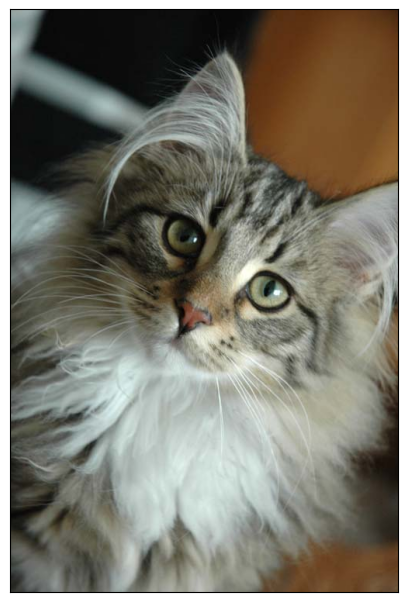

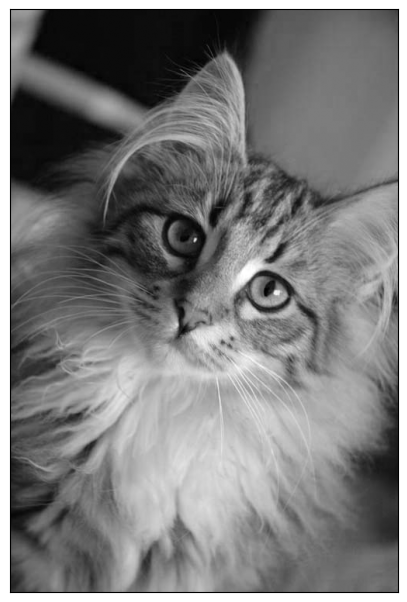

In [19]:
original_image = imread("https://upload.wikimedia.org/wikipedia/commons/d/d9/Norwegian_Forest_Cat_Portrait.JPG")

def display(image):
    # If there is only one channel to show, display it as grayscale
    cm = None
    if(len(image.shape)) == 2:
        cm = "gray"
    plt.figure(figsize = (5, 10))
    plt.imshow(image, cmap = cm)
    plt.xticks([])
    plt.yticks([])
    plt.show()

display(original_image)
r = original_image[:, :, 0]
display(r)

**Convolution** means taking a special square matrix (usually 3x3 or 5x5), called a **convolution kernel** and applying it to the image like this: the central pixel of the resulting image is the sum of element-wise products between the image and the kernel:
![Convolution example](convolution.png)

After that, the kernel moves 1px to the right and contiinues. It "slides" across the entire image. The edge pixels are a bit problematic but there are several ways to deal with that. The most common way is to copy whatever pixel value happened to be at the border.

![Border handling](border.png)

The algorithm is always the same. The output depends on the **kernel**. Different kernels produce different results: some detect edges (lines), others detect corners; some apply blurring and sharpening; some remove noise, etc.

The results can be useful for analyzing what's on the image, or just for artistic purposes.

Let's examine this filter, for example:

$$ F = \begin{bmatrix}
1/9 & 1/9 & 1/9 \\
1/9 & 1/9 & 1/9 \\
1/9 & 1/9 & 1/9
\end{bmatrix}
$$

This calculates the average of all surrounding pixels and basically smooths the image.

Note that in order to preserve brightness, the sum of all elements in $F$ must be equal to 1. If it's not, the image will be darker or brighter (which may or may not be a desired effect).

`scipy.ndimage` has a method for performing 1D and multi-dimensional convolution. Read the docs [here](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.ndimage.filters.convolve.html#scipy.ndimage.filters.convolve).

Apply the convolution. To see better how it performs, you can plot only a part of the image - this will zoom the entire thing. Compare the "before" and "after" images.

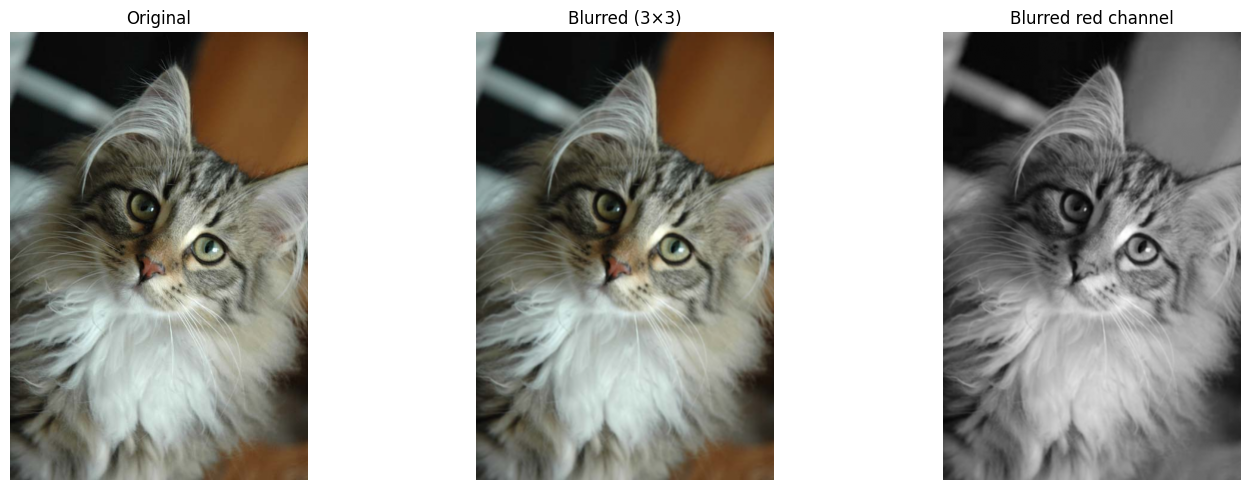

In [20]:
kernel = np.ones((3, 3), dtype=float) / 9.0

blurred_rgb = np.empty_like(original_image)

for ch in range(3):                                  
    blurred_rgb[:, :, ch] = sn.convolve(original_image[:, :, ch],
                                        kernel, mode='nearest')

r_blur = sn.convolve(r, kernel, mode='nearest')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(original_image)
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(blurred_rgb)
axes[1].set_title("Blurred (3×3)")
axes[1].axis('off')

axes[2].imshow(r_blur, cmap='gray')
axes[2].set_title("Blurred red channel")
axes[2].axis('off')

plt.tight_layout()
plt.show()

Play around with more kernels (they're also called **filters**). You can find examples on the Internet, or you can create your own. Have fun :).

Try these filters:
* Gaussian blur
* Sobel edge detector - vertical, horizontal
* Corner detector
* Gradient detector
* Sharpening
* Unsharp mask

For each filter, show the result before and after its application.

Sources: <a href="https://en.wikipedia.org/wiki/Kernel_(image_processing)">Wikipedia</a>, [Image Kernels explained visually](http://setosa.io/ev/image-kernels/).

**Optional:** Think about you might use edge, corner and gradient detectors in image processing.

In [21]:
def to_gray(img):
    if img.ndim == 2:
        return img
    return (0.299 * img[..., 0] +
            0.587 * img[..., 1] +
            0.114 * img[..., 2]).astype(img.dtype)
    
def gaussian_blur(img, sigma=2):
    out = np.empty_like(img)
    for ch in range(3):
        out[..., ch] = sn.gaussian_filter(img[..., ch], sigma=sigma)
    return out

def sobel_x(img):
    return sn.sobel(to_gray(img), axis=1)

def sobel_y(img):
    return sn.sobel(to_gray(img), axis=0)

def gradient_magnitude(img):
    return np.hypot(sobel_x(img), sobel_y(img))

def sharpen(img):
    k = np.array([[0, -1, 0],
                  [-1, 5, -1],
                  [0, -1, 0]], dtype=float)
    out = np.empty_like(img)
    for ch in range(3):
        out[..., ch] = sn.convolve(img[..., ch], k)
    return out

def unsharp_mask(img, sigma=2, amount=1.5):
    blurred = gaussian_blur(img, sigma)
    res = img + amount * (img - blurred)
    return np.clip(res, 0, 255).astype(img.dtype)

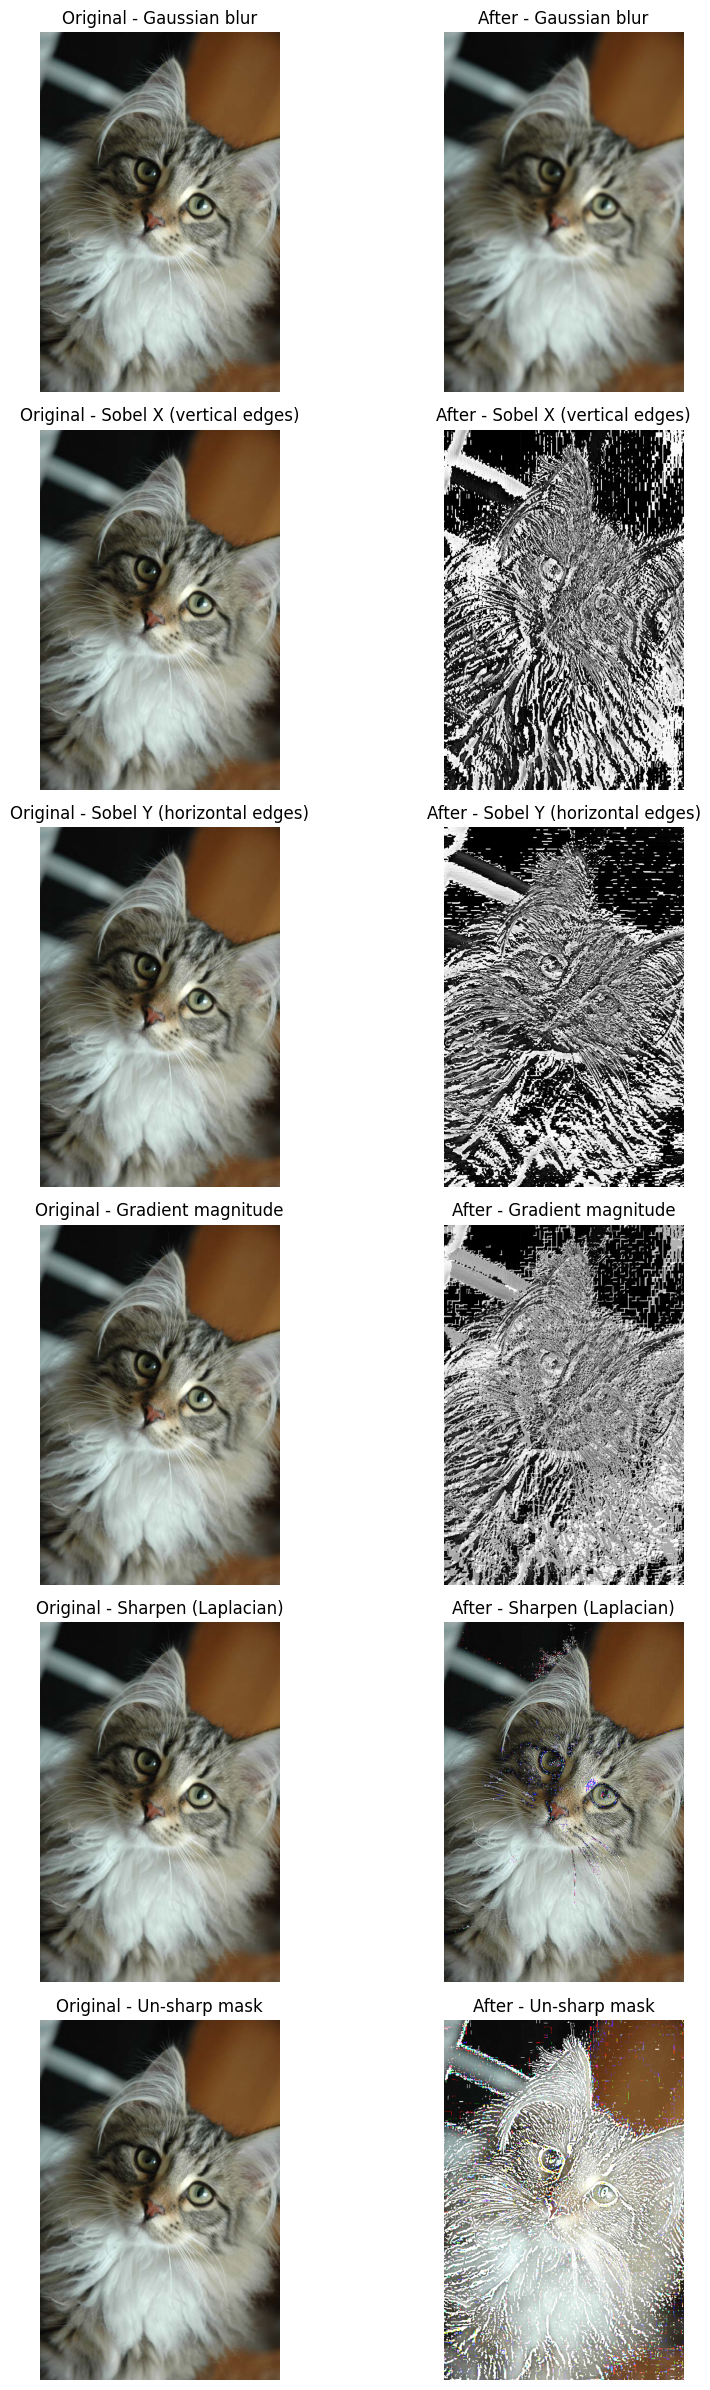

In [22]:
filters = {
    "Gaussian blur": gaussian_blur,
    "Sobel X (vertical edges)": sobel_x,
    "Sobel Y (horizontal edges)": sobel_y,
    "Gradient magnitude": gradient_magnitude,
    "Sharpen (Laplacian)": sharpen,
    "Un-sharp mask": unsharp_mask
}

n = len(filters)
fig, axes = plt.subplots(n, 2, figsize=(10, 4 * n))

for row, (name, func) in enumerate(filters.items()):
    axes[row, 0].imshow(original_image)
    axes[row, 0].set_title(f"Original - {name}")
    axes[row, 0].axis("off")

    result = func(original_image)
    cmap = "gray" if result.ndim == 2 else None
    axes[row, 1].imshow(result, cmap=cmap)
    axes[row, 1].set_title(f"After - {name}")
    axes[row, 1].axis("off")

plt.tight_layout()
plt.show()

### ** Problem 5. Classification
A type of widely used **models** is **classification**. Regression outputs a continuous value while classification outputs one of several pre-defined classes. In the most simple way, the classes are only two. For example, if we want to detect whether there's a cat on an image, we can have two classes: "cat" and "non-cat".

Explore the problem of classification. Implement and document one algorithm. Apply it to some real-world data. You can use the following checklist:

**Note:** If your paper is **about the algorithm**, consider **writing it from scratch**, not reusing it from a library.

* What is supervised learning? What do supervised learning models do?
* What is regression? What is classification?
* What types of problems does classification solve directly?
    * What types of problems can be reduced to classification?
* What's the difference between two-class and multi-class classification?
* Explore one algorithm for classification, e.g. logistic regression.
    * State the problem clearly
    * List all sssumptions of the modelling function
    * Describe the process: distances, error function, total loss, gradient descent, etc.; as needed
    * Implement the algorithm from scratch
* Select or generate a small dataset, suitable for classification. Run your algorithm as a sanity check
* Debug and solve any problems
* Waht is a confusion matrix?
* What metrics are used to score a classifier?
    * Accuracy, Precision, Recall, others
    * ROC curve, interpretation
* Select a real dataset
    * Explore it to get acquainted with what information it contains
    * Clean up the data if you need to do so
    * Perform classification
    * Score your classification model
    * Use your classifier to predict
        * Split the data into training and testing set
        * Optionally, perform **cross-validation**
    * Compare your implementation to another one, e.g. `scikit-learn`. They should give the same (or very similar) results
    * Communicate the results on your dataset
    * Optionally, publish your model on the Internet as a Web API

### Classification

#### Abstract

This article provides a comprehensive overview of supervised classification evaluation, beginning with the regression and classification topic, followed by confusion matrix and its derived metrics (accuracy, precision, recall, F1‑score, specificity, MCC). We discuss the interpretation of ROC and Precision-Recall curves and demonstrate their use for threshold selection. To illustrate these concepts in practice, we implement logistic regression from scratch, train and evaluate it on the Breast Cancer Wisconsin dataset, and compare against scikit‑learn's implementation. The near‑identical performance and high AUC underscore both the validity of the gradient‑descent approach and the importance of proper data splitting, scaling, and metric choice. This end‑to‑end example equips readers with the tools to both quantify and visualize classifier performance.

#### 1. Supervised learning

A) Meaning - a machine‑learning paradigm where each training example comes with a label (a target value supplied by an "oracle" such as a human, a sensor or historical data). Our goal is to find a function $f: X \rightarrow Y$ that maps the input $X$ to output $Y$ by minimizing a loss that measures the gap between predicted and true labels.

B) What models actually do - firstly, models are given paired data to look $(x_i, y_i)$, where $x_i$ might be an image, text file, numbers, etc, $y_i$ - a label ("cat", "dog") or a real number. Then, through algorithms such as gradient descent, the model tweaks $\phi$ so that $f_0(x_i)$ is as close to $y_i$ as possible. After training, the same $f_0$ is applied to unseen inputs.

#### 2. Regression and Classification

A) Regression - our purpose is to predict a continuous, quantitative outcome. A classic baseline is linear regression. Typical evaluation metrics include Mean‑Squared Error (MSE), Root‑MSE, Mean‑Absolute Error (MAE), $R^2$. Examples: predict tomorrow's temperature from meteorological readings, forecast a company's quarterly revenue given historical sales drivers, etc. Formulas:

$$\widehat{y}= \beta_{0}+\boldsymbol{\beta}^{\top}\mathbf{x} \quad \text{(Prediction (linear regression))}$$

$$\operatorname{MSE}= \frac{1}{N}\sum_{i=1}^{N}\bigl(y_i-\widehat{y}_i\bigr)^2 \quad \text{Mean‑squared‑error loss that is minimised to learn the parameters}$$

B) Classification - our purpose is to assign each input $x$ to one of $K$ discrete classes $\set{C_1, \dots, C_k}$. Typical evaluation metrics are Accuracy, Precision, Recall, F1, ROC‑AUC, Log‑loss. Examples include - e‑mail spam filter (Spam vs Not‑Spam), handwritten‑digit recognition (digits 0-9), etc. Formulas:

$$\Pr\!\bigl(Y=1 \mid \mathbf{x}\bigr)=
\sigma\!\bigl(\beta_{0}+\boldsymbol{\beta}^{\top}\mathbf{x}\bigr), \qquad \sigma(z)=\frac{1}{1+e^{-z}} \quad \text{Binary logistic regression (conditional probability of class 1)}$$

$$\mathcal{L}= -\frac{1}{N}\sum_{i=1}^{N}
\Bigl[y_i\log\hat{p}_i + (1-y_i)\log\bigl(1-\hat{p}_i\bigr)\Bigr] \quad \text{Cross‑entropy (log‑loss) minimised during training}$$

C) Key features and differences - output type is the divider: continuous $\rightarrow$ regression; categorical $\rightarrow$ classification. Loss functions differ (squared error vs cross-entropy) because the notion of "mistake" is different. Probabilistic interpretation: regression predicts a conditional mean; classification estimates class probabilities.

#### 3. Solving Problems with Classification

Classification tackles any task where each input must be assigned to one label chosen from a finite set of predefined classes. Typical examples - object / scene recognition - is the picture a cat, dog, or car? E‑mail filtering – Spam vs. Non-spam. Sentiment analysis – Review - positive, neutral, or negative, etc. Here the desired answer really is a categorical tag, so classification models (logistic regression, decision trees, SVMs, neural nets, ...) are the natural fit. Many tasks whose outputs are not naturally categorical can be reformulated so that a classifier can still be used. Even when a task isn't obviously about "picking a label", we can still turn it into one by framing the goal in terms of everyday yes-or-no (or small‑set) choices. Spam filtering - E‑mails arrive with varied wording and length, but we only need a classifier that says "spam" or "not spam". Sentiment analysis - Movie reviews are long pieces of text; we rephrase the job as deciding whether a review is "positive", "negative" or perhaps "neutral". Face unlock on a phone: The camera captures continuous image data, but the system just has to return "owner's face" or "not owner".

#### 4. Two-class vs multi-class classification

A) Two-Class Classification - in two-class (binary) classification every observation must be assigned to exactly one of two mutually exclusive labels - for example, "spam vs. not‑spam", "diseased vs. healthy". Mathematically, the target variable $y$ takes values in $\set{0,1}$. Many algorithms (logistic regression, a single-output perceptron, a basic SVM) are natively designed for this setting and learn a decision boundary that splits the feature space into "class 0" and "class 1".

B) Multi-Class Classification - in multi‑class classification the model must choose among three or more possible labels, so $y \in \set{1, \dots, K}$ with $K \gt 2$. Some algorithms handle this directly - for example, a neural network with a soft‑max output layer or a decision tree whose leaves correspond to different classes. Others that are inherently binary (like a classic SVM) require a strategy such as one‑vs‑rest or one‑vs‑one to extend them to the multi‑class case. Thus, the key difference is the number of possible categories and, consequently, whether the learner can be applied as‑is or needs a decomposition scheme to manage multiple labels.

#### 5. Exploring binary logistic regression

A) Problem statement

Given a labelled data set
$$
\mathcal D=\{(\mathbf x^{(i)},y^{(i)})\}_{i=1}^{m},
\qquad
\mathbf x^{(i)}\in\mathbb R^{d},\;
y^{(i)}\in\{0,1\},
$$
the goal of logistic regression is to learn a function that predicts whether a new point belongs to the positive class.
We assume (1) the log‑odds of the class probability is linear in the features, (2) samples are i.i.d., (3) labels follow a Bernoulli distribution given the features, and (4) there is no perfect multicollinearity among features.

B) Model

The model (hypothesis) is
$$
h_\theta(\mathbf x)=\sigma\!\bigl(\theta^{\!\top}\mathbf x\bigr)=\frac{1}{1+e^{-\theta^{\!\top}\mathbf x}},
$$
where $\sigma$ is the logistic (sigmoid) function.

C) Loss

The empirical cross‑entropy (negative log‑likelihood) loss over $m$ samples is
$$
\mathcal L(\theta)=
-\frac1m\sum_{i=1}^{m}
\Bigl[
y^{(i)}\ln h_\theta(\mathbf x^{(i)})+
\bigl(1-y^{(i)}\bigr)\ln\bigl(1-h_\theta(\mathbf x^{(i)})\bigr)
\Bigr].
$$

D) Gradient and learning rate

Its gradient is
$$
\nabla_\theta\mathcal L=
\frac1m\sum_{i=1}^{m}
\bigl(h_\theta(\mathbf x^{(i)})-y^{(i)}\bigr)\,\mathbf x^{(i)}.
$$

With a learning rate $\alpha>0$, batch gradient descent updates the parameters by
$$
\theta\;\leftarrow\;\theta-\alpha\,\nabla_\theta\mathcal L.
$$


In [23]:
def sigmoid(z):
    """
    Compute sigmoid function
    """
    
    return 1.0 / (1.0 + np.exp(-z))

class LogisticRegressionScratch:
    """
    Class for evaluation logistic regression from scratch
    """
    
    def __init__(self, lr=0.1, n_iters=10000):
        self.lr = lr
        self.n_iters = n_iters

    def fit(self, X, y):
        m, d = X.shape
        self.theta = np.zeros(d)
        for _ in range(self.n_iters):
            preds = sigmoid(X @ self.theta)
            grad  = (1/m) * (X.T @ (preds - y))
            self.theta -= self.lr * grad

    def predict_proba(self, X):
        return sigmoid(X @ self.theta)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

In [24]:
# Randomly generated dataset

np.random.seed(0)
n = 50
x_pos = np.random.randn(n, 2) + np.array([ 2,  2])
x_neg = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack((x_pos, x_neg))
y = np.hstack((np.ones(n), np.zeros(n)))

model = LogisticRegressionScratch(lr=0.1, n_iters=1000)
model.fit(X, y)
print(f"training accuracy: {(model.predict(X) == y).mean():.2%}")

training accuracy: 100.00%


#### 6. Confusion Matrix

A) Meaning - a contingency table that cross‑tabulates a classifier's predictions against the true class labels, letting us see not only how many cases were classified correctly but how the errors are distributed. For a binary classifier the matrix has 2 rows (actual classes) and 2 columns (predicted classes):

$$
\begin{array}{c|cc}
      & \text{Predicted Positive} & \text{Predicted Negative} \\ \hline
\text{Actual Positive} & TP & FN \\
\text{Actual Negative} & FP & TN
\end{array}
$$

From these four counts we can derive the standard evaluation measures:

For a multi‑class problem (say $k$ classes) the matrix becomes $k\times k$. Entry $(i,j)$ holds the number of samples whose true class is $i$ but were predicted as $j$. The diagonal still represents correct predictions, the off‑diagonal cells show the specific mis‑classifications, revealing which classes the model tends to confuse.

#### 7. Scoring a classifier

A confusion matrix for a binary classifier summarizes the counts of correct and incorrect predictions:

$$ 
\begin{array}{c|cc}
 & \text{Predicted Positive} & \text{Predicted Negative} \\
\text{Actual Positive} & TP & FN \\
\text{Actual Negative} & FP & TN
\end{array}
$$

From these four quantities we derive the most common metrics:

$$
\begin{array}{@{}lcc@{}}
\textbf{Metric}    & \textbf{Formula}                                                    & \textbf{Interpretation}            \\            
\text{Accuracy}    & \displaystyle\frac{TP + TN}{TP + TN + FP + FN}                     & \text{Overall fraction correct}                \\
\text{Precision}   & \displaystyle\frac{TP}{TP + FP}                                    & \text{Correctness of positive predictions}     \\
\text{Recall (TPR)}& \displaystyle\frac{TP}{TP + FN}                                    & \text{Coverage of true positives}              \\
\text{Specificity} & \displaystyle\frac{TN}{TN + FP}                                    & \text{Coverage of true negatives}              \\
\text{F1‑Score}    & \displaystyle 2 \times \,\frac{\text{Precision}\times\text{Recall}}{\text{Precision}+\text{Recall}} & \text{Harmonic mean of precision \& recall} \\
\text{FPR}         & \displaystyle\frac{FP}{FP + TN}                                    & \text{False‑alarm rate (x‑axis of ROC)}        \\
\text{MCC}         & \displaystyle\frac{TP\cdot TN - FP\cdot FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}} & \text{Balanced correlation}
\end{array}
$$

#### 8. Experimentation

              Accuracy  Precision    Recall  F1‑Score       AUC
Model                                                          
Scratch       0.988304   0.990654  0.990654  0.990654  0.997810
Scikit‑learn  0.988304   0.990654  0.990654  0.990654  0.998102


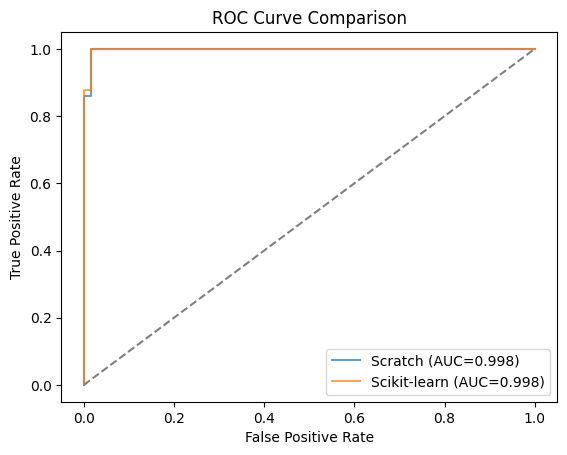

In [25]:
# Load and split
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# Our scratch implementation
scratch = LogisticRegressionScratch()
scratch.fit(X_train_s, y_train)
y_pred_s = scratch.predict(X_test_s)
y_proba_s = scratch.predict_proba(X_test_s)

# scikit-learn model
sk = LogisticRegression(max_iter=10000).fit(X_train_s, y_train)
y_pred_sk = sk.predict(X_test_s)
y_proba_sk = sk.predict_proba(X_test_s)[:,1]

# Compute metrics for both
results = []
for name, y_pred, y_proba in [
    ("Scratch", y_pred_s, y_proba_s),
    ("Scikit‑learn", y_pred_sk, y_proba_sk)
]:
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1‑Score": f1,
        "AUC": auc_score
    })

df_cmp = pd.DataFrame(results).set_index("Model")
print(df_cmp)

# Plot ROC curves
plt.figure()
for name, y_proba in [("Scratch", y_proba_s), ("Scikit‑learn", y_proba_sk)]:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})", alpha = 0.7)

plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

#### 9. Conclusion

In this article, we have shown how a simple confusion matrix - augmented with metrics like precision, recall, F1‑score, and MCC - serves as the foundation for understanding classifier behavior, while ROC and Precision-Recall curves offer a complete view across all decision thresholds. Our from-scratch logistic regression implementation, validated against a Python library, demonstrates that clear theoretical understanding paired with disciplined preprocessing (train/test split, scaling) yields robust models. Moving forward, people should choose evaluation metrics that align with real‑world costs, consider cross‑validation and regularization to ensure stability. By combining transparency in implementation with evaluation, we can build classifiers that are both interpretable and performant.

### ** Problem 6. Fourier Transform Applications: Images
Examine how Fourier transform is used in image processing. Consider writing the algorithms for transformation (forward and inverse) from scratch.

You may look at other transformations as well, for example, the **cosine transform** (used in JPEG images to achieve compression) or **wavelet transform**. You can use the following checklist:

* What is Fourier transformation? What information does it provide?
    * What do the forward and inverse transformation do? What are their inputs and outputs?
    * How do we interpret the results ("time domain" / "frequency domain")?
        * What does this mean in 2D? How does a 1D spectrum differ from a 2D spectrum?
        * What are the characteristic parts of a 2D spectrum?
    * Give some examples of well-known functions and their transformations
* What is Discrete Fourier Transform (DFT)?
    * Implement the algorithm in 2D
* How do we use DFT in image processing?
    * Provide examples
* Select an image and perform operations on it using your implementation of DFT
    * Low-pass filtering
    * High-pass filtering
    * Finding and removal of periodic component from an image
    * Fnding and removal of peaks
    * Shape analysis
* How do convolutions relate to DFT?
    
[This document](http://www.robots.ox.ac.uk/~az/lectures/ia/lect2.pdf), [this document](http://research.stowers.org/mcm/efg/Report/FourierAnalysis.pdf), and many others provide a good starting point. You can find a lot of examples in digital image processing and art using Fourier transformations.

### Fourier Transform in Images

#### Abstract

We present a hands‑on demonstration of how the 2D Discrete Fourier Transform (DFT) can powerfully transform and analyze digital images. Using the classic "camera" test image, we first compute its frequency spectrum to reveal underlying sinusoidal patterns. We then apply a low‑pass filter to smooth out high‑frequency noise and a high‑pass filter to accentuate edges and fine detail. Next, we remove periodic artifacts by thresholding and manually suppress the strongest spectral peaks, illustrating practical strategies for cleaning up repetitive interference. Finally, we perform a simple shape analysis on the low‑pass result-using Otsu's thresholding and region labeling-to detect and measure distinct objects. Together, these steps showcase a complete workflow for frequency‑domain filtering, artifact removal, and basic morphological analysis.

#### 1. Fourier Transform

A) Meaning - the Fourier transform is an integral operator that decomposes any (suitably well‐behaved) function $f(t)$ into a continuous superposition of complex exponentials (sinusoids). Formally, for a 1D signal $f(t)$:

$$ F(\omega) = \int_{-\infty}^{\infty} f(t) e^{-j\omega t}\,dt $$

B) Forward vs. inverse transform - the forward transform's input is time‐/space‐domain signal, the output is complex spectrum, indexed by angular frequency $\omega$. The inverse one's input is frequency‐domain spectrum, output - reconstructed time‐/space‐domain signal. Together they satisfy perfect invertibility (under mild conditions). Inverse formula:

$$f(t) = \frac{1}{2\pi}\int_{-\infty}^{\infty} F(\omega)e^{j\omega t}\, d\omega $$

C) Time‑domain vs. frequency‑domain interpretation - time (or spatial) domain shows "what happens when" (or "where in the image"). Frequency domain shows "what sinusoids compose it" - low frequencies mean slow variations (in images: smooth regions), whereas high frequencies mean rapid changes (edges, noise). Switching domains lets us filter (e.g. remove noise by zeroing high $\omega$) or compress (keep only the strongest few frequencies).

D) From 1D to 2D - For a 2D function (image) $f(x,y)$, the transform is:

$$ F(u,v) = \iint_{-\infty}^{\infty} f(x,y)e^{-j2\pi(ux + vy)}\,dx\,dy $$

1D spectrum is a line, 2D spectrum is a plane: each point encodes a sinusoid at spatial frequencies u (horizontal) and v (vertical).

E) Characteristic parts of a 2D spectrum - DC component at $(u,v)=(0,0)$ (overall average brightness), low‑frequency region around the center (smooth variations), high‑frequency corners (diagonal edge detail/noise), symmetry - for real images $f,\quad F(-u,-v) = \overline{F(u,v)}$, orientation info - peaks along horizontal or vertical axes reveal repetitive patterns (e.g. stripes), etc.

F) Example functions and their transforms:

$$
\begin{array}{lll}
\textbf{Function } f(t) & \textbf{Transform } F(\omega) & \textbf{Comments} \\[6pt]
\hline\\[-6pt]
\delta(t) & 1 & \text{All frequencies equally present.} \\[6pt]
1 & 2\pi\delta(\omega) & \text{Only DC component.} \\[6pt]
\sin(\omega_0 t) & \pi\left[j\delta(\omega+\omega_0)-j\delta(\omega-\omega_0)\right] & \text{Impulses at } \pm\omega_0. \\[6pt]
\cos(\omega_0 t) & \pi\left[\delta(\omega-\omega_0)+\delta(\omega+\omega_0)\right] & \text{Two symmetric impulses.} \\[6pt]
\text{Rectangular pulse width } T & T\,\text{sinc}\left(\frac{\omega T}{2}\right) & \text{Sinc envelope → ripples in frequency.} \\[6pt]
\exp\left(-\frac{t^2}{2\sigma^2}\right) & \sigma\sqrt{2\pi}\,\exp\left(-\frac{\omega^2\sigma^2}{2}\right) & \text{Gaussian ↔ Gaussian ("self-similar").}
\end{array}
$$

#### 2. Discrete Fourier Transform (DFT)

A) Meaning

Purpose: Converts a discrete $M\times N$ image $f[m,n]$ (spatial domain) into its frequency-domain representation $F[u,v]$.

Forward formula:
$$
F[u,v] = \sum_{m=0}^{M-1}\sum_{n=0}^{N-1} f[m,n] \exp\left(-2\pi j\left(\frac{um}{M}+\frac{vn}{N}\right)\right),\quad u=0,\dots,M-1;\; v=0,\dots,N-1.
$$

Input: real (or complex) array $f[m,n]$.

Output: complex array $F[u,v]$, whose magnitude $|F|$ shows “how much” of each horizontal frequency $u$ and vertical frequency $v$ is present, and whose phase $\arg F$ encodes shifts.

Inverse formula:
$$
f[m,n] = \frac{1}{MN}\sum_{u=0}^{M-1}\sum_{v=0}^{N-1}F[u,v]\exp\left(+2\pi j\left(\frac{um}{M}+\frac{vn}{N}\right)\right).
$$

Input: frequency spectrum $F[u,v]$.

Output: reconstructed image $f[m,n]$.

Why 2D?  
In images, variations occur across two axes. The 2D DFT captures horizontal and vertical sinusoidal components, letting us filter, compress, or analyze patterns (e.g., edges appear as high-frequency content).

Computational cost: naïvely $O(M^2 N^2)$; practical libraries use FFT to drop to $O(MN\log(MN))$.


In [26]:
def dft2d(x):
    """
    Compute the 2D Discrete Fourier Transform manually.
    """
    
    M, N = x.shape
    X = np.zeros((M, N), dtype=complex)
    for u in range(M):
        for v in range(N):
            sum_val = 0.0 + 0.0j
            for m in range(M):
                for n in range(N):
                    angle = -2j * np.pi * ((u * m / M) + (v * n / N))
                    sum_val += x[m, n] * np.exp(angle)
            X[u, v] = sum_val
    return X

def idft2d(X):
    """
    Compute the 2D Inverse Discrete Fourier Transform manually.
    """
    
    M, N = X.shape
    x_rec = np.zeros((M, N), dtype=complex)
    for m in range(M):
        for n in range(N):
            sum_val = 0.0 + 0.0j
            for u in range(M):
                for v in range(N):
                    angle = 2j * np.pi * ((u * m / M) + (v * n / N))
                    sum_val += X[u, v] * np.exp(angle)
            x_rec[m, n] = sum_val / (M * N)
    return x_rec

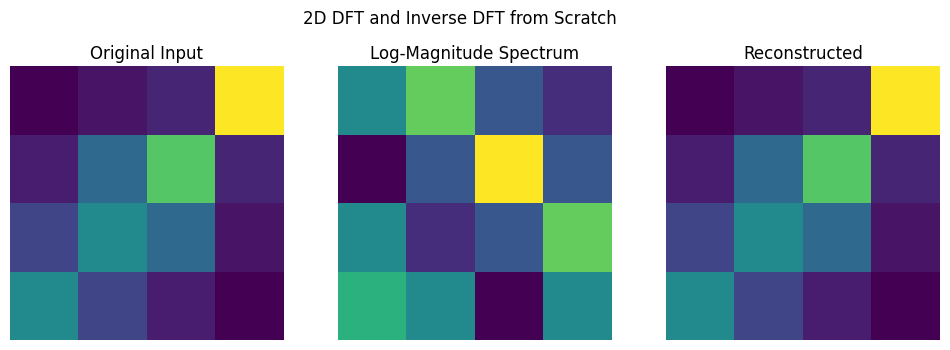

In [27]:
# Test on a small example
x = np.array([
    [100,  50,  25,  10],
    [ 50, 100,  75,  20],
    [ 25,  75, 150,  30],
    [ 10,  20,  30, 200]
], dtype=float)

# Forward DFT
X = dft2d(x)

# Inverse DFT
x_rec = idft2d(X)

# Display original, magnitude spectrum, and reconstructed
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(x, origin='lower')
axes[0].set_title('Original Input')
axes[0].axis('off')

axes[1].imshow(np.log1p(np.abs(np.fft.fftshift(X))), origin='lower')
axes[1].set_title('Log-Magnitude Spectrum')
axes[1].axis('off')

axes[2].imshow(np.real(x_rec), origin='lower')
axes[2].set_title('Reconstructed')
axes[2].axis('off')

plt.suptitle('2D DFT and Inverse DFT from Scratch')
plt.show()

#### 3. DFT in image processing - examples

1. Frequency‑Domain Filtering

a) Low‑pass (smoothing)

Goal - Remove high‑frequency noise, keep smooth variations.  

```python

# 1) Compute 2D DFT
F = DFT2D(f)

# 2) Build distance mask
U, V = np.meshgrid(np.arange(N), np.arange(M))
D = np.sqrt((U - N/2)**2 + (V - M/2)**2)

# 3) Zero out frequencies beyond cutoff R
R = 30  # cutoff radius
F_low = F.copy()
F_low[D > R] = 0

# 4) Inverse DFT to reconstruct
f_smooth = np.real(IDFT2D(ifftshift(F_low)))

```

b) High‑pass (edge enhancement)

Goal: Emphasize edges and fine detail.

```python
# 1) Compute 2D DFT
F = DFT2D(f)

# 2) Build distance mask
U, V = np.meshgrid(np.arange(N), np.arange(M))
D = np.sqrt((U - N/2)**2 + (V - M/2)**2)

# 3) Zero out frequencies within cutoff R
R = 30  # cutoff radius
F_high = F.copy()
F_high[D < R] = 0

# 4) Inverse DFT to reconstruct edges
f_edges = np.real(IDFT2D(ifftshift(F_high)))
```

2. Fast Convolution via Multiplication
 
Goal: Convolve with a large kernel in $O(MNlog(MN))$ instead of $O(M^2N^2)$

```python
# 1) Zero‑pad image and kernel to same shape
f_pad = zero_pad(f, M_out, N_out)
h_pad = zero_pad(h, M_out, N_out)

# 2) Compute 2D DFTs
F = DFT2D(f_pad)
H = DFT2D(h_pad)

# 3) Pointwise multiply
G = F * H

# 4) Inverse DFT to get convolution result
g = np.real(IDFT2D(G))
```

3. Image Compression (JPEG DCT)

Goal: Reduce storage by discarding perceptually insignificant frequencies.

```python
# 1) Divide image into 8×8 blocks
blocks = view_as_blocks(image, (8,8))

# 2) Apply 2D DCT to each block
C = np.array([[DCT2D(block) for block in row] for row in blocks])

# 3) Quantize with standard JPEG quantization matrix Q
C_q = np.round(C / Q)

# 4) Store C_q, then inverse steps to reconstruct
C_deq = C_q * Q
blocks_rec = np.array([[IDCT2D(c) for c in row] for row in C_deq])
image_rec = reconstruct_from_blocks(blocks_rec)
```

4. Image Registration via Phase Correlation

Goal: Find translation offset $(\Delta x,\Delta y)$ between two images.

```python
# 1) Compute 2D DFTs of both images
F1 = DFT2D(img1)
F2 = DFT2D(img2)

# 2) Compute cross‑power spectrum
R = (F1 * np.conj(F2)) / np.abs(F1 * np.conj(F2))

# 3) Inverse DFT to get correlation surface
corr = np.real(IDFT2D(R))

# 4) Peak location gives (Δy, Δx)
dy, dx = np.unravel_index(np.argmax(corr), corr.shape)
```

5. Feature & Texture Analysis

Goal: Detect dominant spatial frequencies and orientations.

```python
# 1) Compute 2D DFT and shift zero-frequency to center
F = np.fft.fftshift(DFT2D(f))

# 2) Compute log-magnitude spectrum
mag = np.log1p(np.abs(F))

# 3) Threshold and find peak coordinates away from center
peaks = find_peaks_2d(mag, threshold=0.5*mag.max())

# 4) Compute angles of peaks for texture orientation
angles = np.arctan2(peaks[:,0] - M/2, peaks[:,1] - N/2)
```

6. Watermarking & Steganography

Goal: Embed and retrieve a hidden watermark in mid‑frequency DFT coefficients.

```python
# 1) Compute 2D DFT
F = DFT2D(f)

# 2) Create mid-frequency mask
mask = create_midfreq_mask(M, N, r_inner=20, r_outer=50)

# 3) Embed watermark W with strength alpha
alpha = 0.01
F_wm = F + alpha * W * mask

# 4) Inverse DFT to get watermarked image
f_wm = np.real(IDFT2D(F_wm))

# Retrieval:
F2 = DFT2D(f_wm)
W_rec = (F2 - F) / (alpha * mask)
```

#### 4. Playing with an image - example

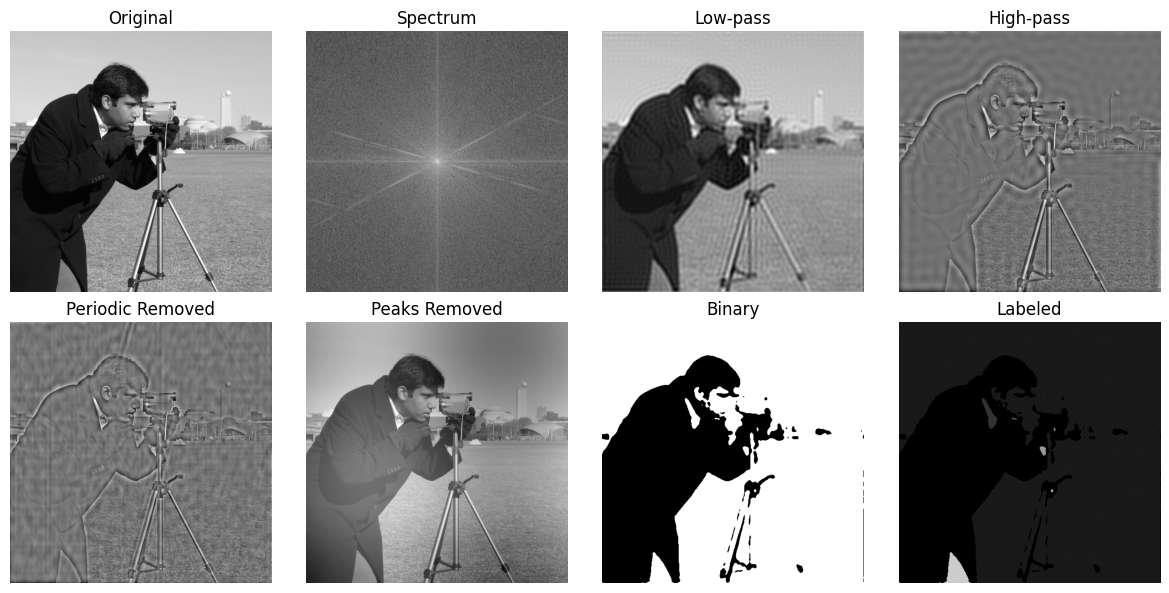

In [28]:
# Load and prepare
image = camera()
F = fft2(image)
F_shifted = fftshift(F)
magnitude_spectrum = np.log1p(np.abs(F_shifted))

M, N = image.shape
U, V = np.meshgrid(np.arange(N), np.arange(M))
D = np.sqrt((U - N/2)**2 + (V - M/2)**2)

# Low-pass and High-pass
R_low, R_high = 50, 20
F_low = F_shifted.copy(); F_low[D > R_low] = 0
image_low = np.real(ifft2(ifftshift(F_low)))
F_high = F_shifted.copy(); F_high[D < R_high] = 0
image_high = np.real(ifft2(ifftshift(F_high)))

# Periodic removal
mag = np.abs(F_shifted)
threshold = np.percentile(mag, 99.5)
F_no_periodic = F_shifted.copy(); F_no_periodic[mag > threshold] = 0
image_no_periodic = np.real(ifft2(ifftshift(F_no_periodic)))

# Remove top peaks
coords = np.argwhere(mag > threshold)
top_idx = np.argsort(mag[coords[:,0], coords[:,1]])[-5:]
peak_coords = coords[top_idx]
F_peaks_removed = F_shifted.copy()
for y, x in peak_coords:
    F_peaks_removed[y, x] = 0
image_peaks_removed = np.real(ifft2(ifftshift(F_peaks_removed)))

# Shape analysis on low-pass
thresh = threshold_otsu(image_low)
binary = image_low > thresh
labeled = label(binary)
regions = regionprops(labeled)

# Plot smaller grid 2x4
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()
imgs = [image, magnitude_spectrum, image_low, image_high,
        image_no_periodic, image_peaks_removed, binary, labeled]
titles = ["Original", "Spectrum", "Low-pass", "High-pass",
          "Periodic Removed", "Peaks Removed", "Binary", "Labeled"]

for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

#### 5. Convolutions

Convolutions and the Discrete Fourier Transform are linked by the Convolution Theorem, which tells us that convolving two signals (or images) in the spatial domain is equivalent to pointwise multiplying their DFTs in the frequency domain. In practice, we take the DFT of our image and of our kernel, multiply them element‑by‑element, and then apply the inverse DFT to recover the convolved result. This approach is not only mathematically elegant-since it turns the expensive $O(M^2 N^2)$ double sum of direct convolution into an $O(MN\log(MN))$ sequence of FFTs and a simple multiplication-but also crucial for implementing large filters, real‑time processing, and deep‑learning layers efficiently.

#### 6. Conclusion

This article confirms that DFT‑based operations offer a unified, efficient framework for both enhancing and extracting information from images. Low‑pass filtering effectively denoises, while high‑pass filtering sharpens structural features. Periodic component removal and peak suppression demonstrate how targeted spectral editing can eliminate unwanted patterns without resorting to complex spatial masks. The subsequent shape analysis highlights the synergy between frequency‑domain preprocessing and spatial‑domain object detection. Looking forward, integrating adaptive cutoff selection, multi‑scale transforms, or real‑time FFT implementations could further extend these techniques to video streams, biomedical imaging, and machine‑vision applications—making DFT an indispensable tool in the modern image‑processing toolbox.